In [127]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as pdr
import os
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
yf.pdr_override()
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']

In [4]:
startdate = dt.datetime(2015,1,1)
enddate = dt.datetime(2021,1, 1)

In [5]:
data = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)

[*********************100%%**********************]  5 of 5 completed


In [6]:
data.head()

Adj Close                                                Close   
                 AAPL     AMZN       GOOG       MSFT       TSLA       AAPL   
Date                                                                         
2015-01-02  24.498680  15.4260  26.168653  40.534843  14.620667  27.332500  \
2015-01-05  23.808517  15.1095  25.623152  40.162094  14.006000  26.562500   
2015-01-06  23.810755  14.7645  25.029282  39.572617  14.085333  26.565001   
2015-01-07  24.144638  14.9210  24.986401  40.075401  14.063333  26.937500   
2015-01-08  25.072325  15.0230  25.065184  41.254341  14.041333  27.972500   

                                                      ...       Open            
               AMZN       GOOG       MSFT       TSLA  ...       AAPL     AMZN   
Date                                                  ...                       
2015-01-02  15.4260  26.168653  46.759998  14.620667  ...  27.847500  15.6290  \
2015-01-05  15.1095  25.623152  46.330002  14.006000  ...  27.072500  15.3505   
2015-01-06  14.7645  25.029282  45.650002  14.085333  ...  26.635000  15.1120   
2015-01-07  14.9210  24.986401  46.230000  14.063333  ...  26.799999  14.8750   
2015-01-08  15.0230  25.065184  47.590000  14.041333  ...  27.307501  15.0160   

                                                Volume                       
                 GOOG       MSFT       TSLA       AAPL      AMZN      GOOG   
Date                                                                         
2015-01-02  26.378078  46.660000  14.858000  212818400  55664000  28951268  \
2015-01-05  26.091366  46.369999  14.303333  257142000  55484000  41196796   
2015-01-06  25.679497  46.380001  14.004000  263188400  70380000  57998800   
2015-01-07  25.280592  45.980000  14.223333  160423600  52806000  41301082   
2015-01-08  24.831326  46.750000  14.187333  237458000  61768000  67071641   

                                
                MSFT      TSLA  
Date                            
2015-01-02  27913900  71466000  
2015-01-05  39673900  80527500  
2015-01-06  36447900  93928500  
2015-01-07  29114100  44526000  
2015-01-08  29645200  51637500  

[5 rows x 30 columns]

Text(0.5, 1.0, 'Stock prices')

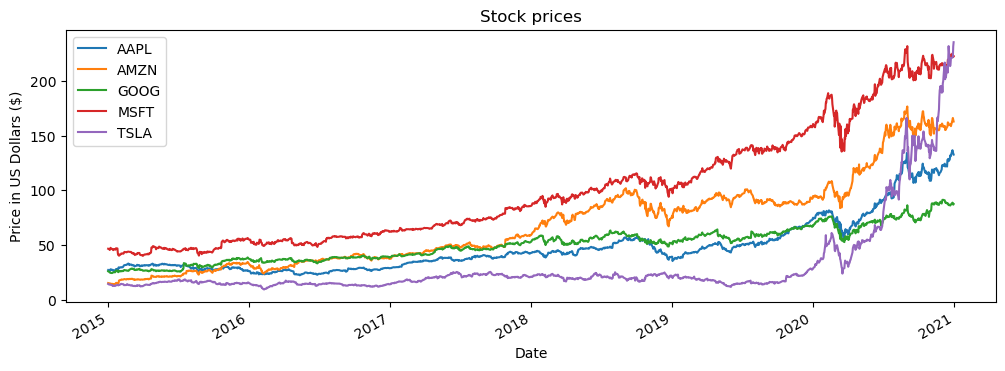

In [7]:
data.Close.plot(figsize = (12, 4))
plt.xlabel('Date')
plt.ylabel('Price in US Dollars ($)')
plt.title('Stock prices')

Most of the variation seems to happen between 2020 and 2021. Lets take a closer look

<Axes: xlabel='Date'>

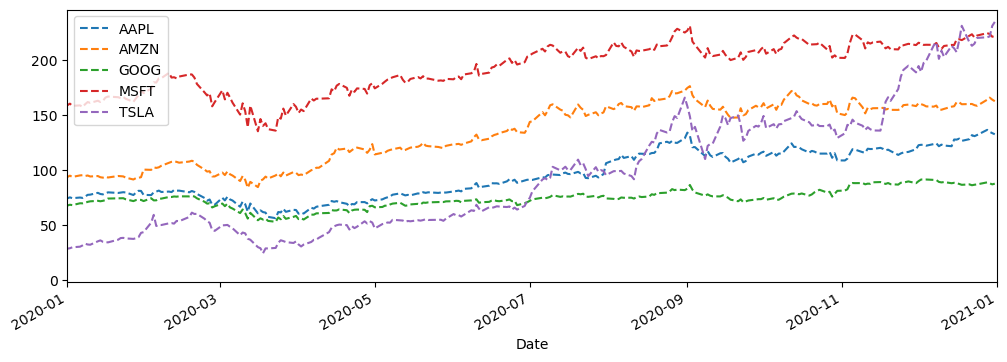

In [8]:
data.Close.plot(xlim = ['2020-01-01', '2021-01-01'], ls = '--', figsize = (12, 4))

### ANALYZE APPLE STOCK

In [9]:
data_aapl = pdr.get_data_yahoo(['AAPL'], start='2015-01-01', end='2019-12-31')
data_aapl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.498678,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.808516,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.810760,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.144634,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.072329,237458000


In [10]:
data_aapl.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,38.572389,38.911619,38.241615,38.591462,36.419353,1.436337e+08
std,10.965114,11.064943,10.887390,10.990491,11.189187,7.155630e+07
min,22.500000,22.917500,22.367500,22.584999,20.826057,4.544800e+07
25%,28.950001,29.129999,28.625000,28.875000,26.416534,9.511960e+07
50%,37.567501,37.957500,37.290001,37.637501,35.542965,1.263232e+08
75%,46.450001,46.832500,46.145000,46.465000,44.483959,1.715400e+08
max,72.779999,73.492500,72.029999,72.879997,71.095573,6.488252e+08


<Axes: xlabel='Date'>

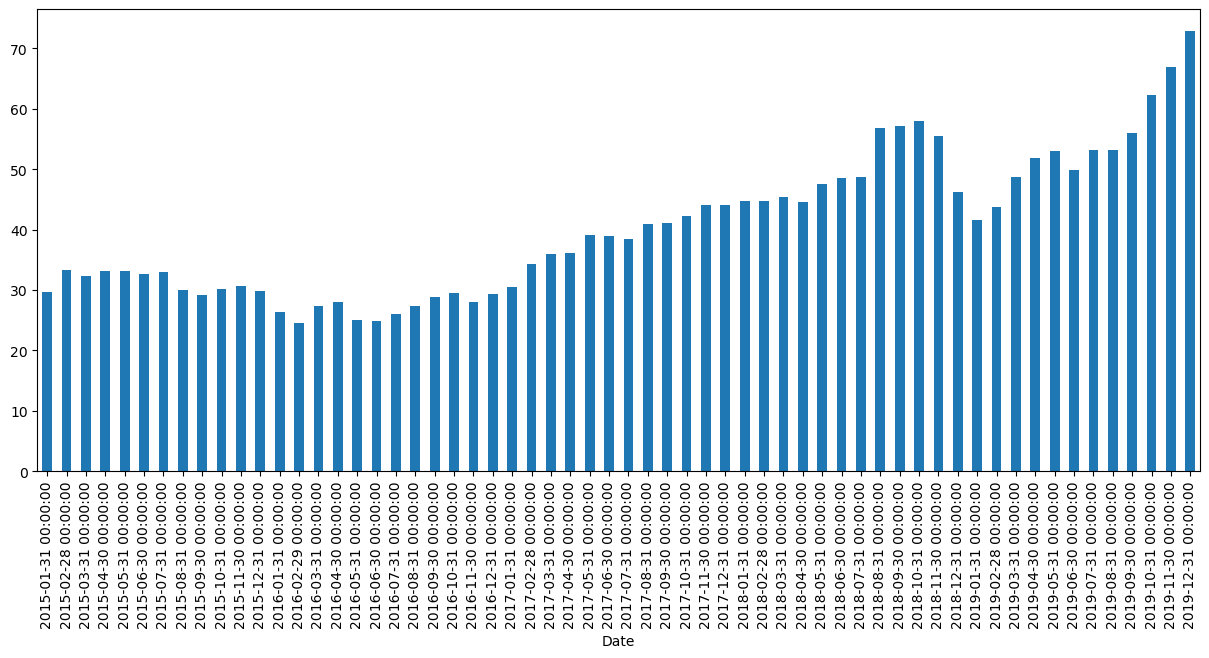

In [11]:
data_aapl.Close.resample(rule = 'M').max().plot(kind = 'bar', figsize = (15, 6))

Text(0, 0.5, 'Prices')

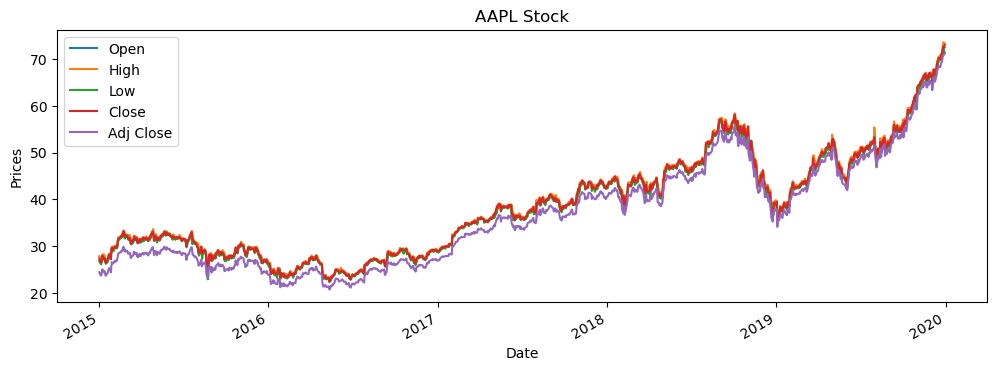

In [12]:
data_aapl.iloc[:, :-1].plot(figsize = (12, 4))
plt.title('AAPL Stock')
plt.ylabel('Prices')

<Axes: xlabel='Date'>

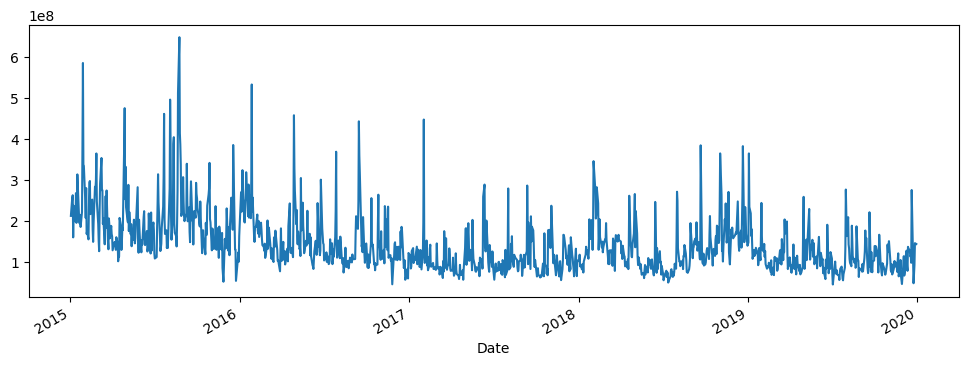

In [13]:
data_aapl.Volume.plot(figsize = (12, 4))

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

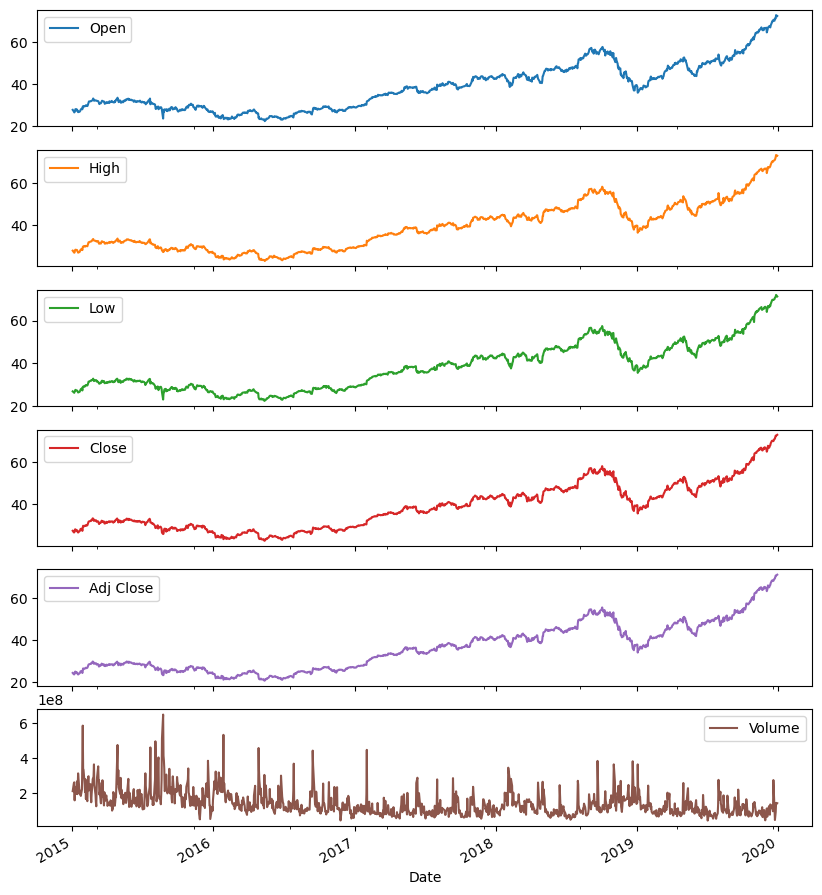

In [14]:
data_aapl.plot(subplots = True, figsize = (10, 12))

Lets look at the close value of the stock

<Axes: xlabel='Date'>

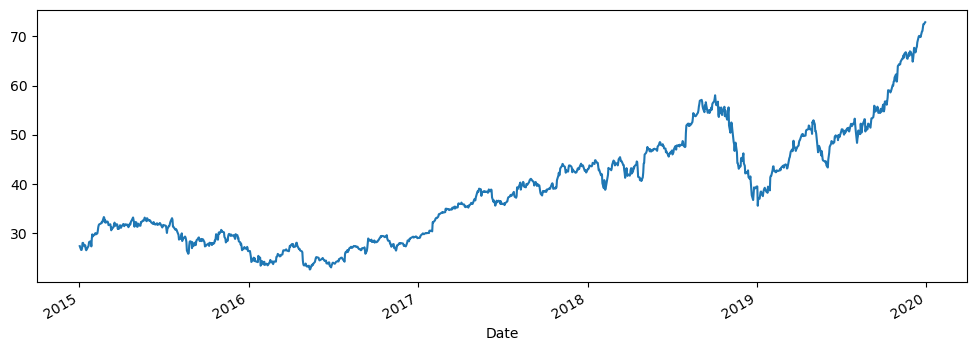

In [15]:
data_aapl.Close.plot(figsize = (12, 4))

Text(0.5, 1.0, 'Distribution of close prices over the days')

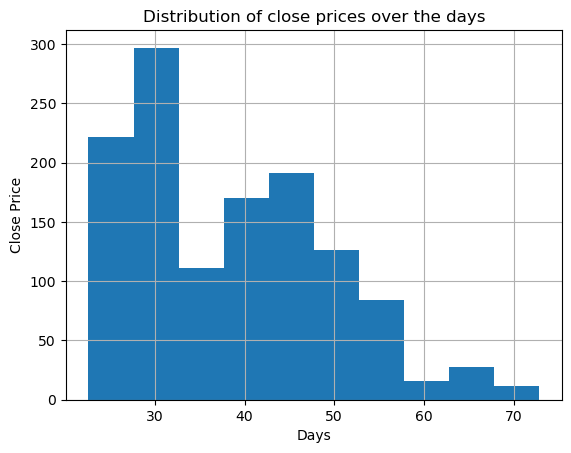

In [16]:
data_aapl.Close.hist()
plt.ylabel('Close Price')
plt.xlabel('Days')
plt.title('Distribution of close prices over the days')

In [17]:
data_aapl.Close.rolling(10).mean()

Date
2015-01-02          NaN
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
                ...    
2019-12-23    69.233249
2019-12-24    69.627998
2019-12-26    70.106499
2019-12-27    70.564999
2019-12-30    70.974249
Name: Close, Length: 1257, dtype: float64

### Simple Moving Average

Moving Average:
Average of the last n days

In [18]:
#Calculate moving average of first 50 days
ma20 = data_aapl.Close.rolling(20).mean()
#Calculate moving average of first 50 days
ma50 = data_aapl.Close.rolling(50).mean()
#Calculate moving average of first 100 days
ma100 = data_aapl.Close.rolling(100).mean()
#Calculate moving average of first 200 days
ma200 = data_aapl.Close.rolling(200).mean()

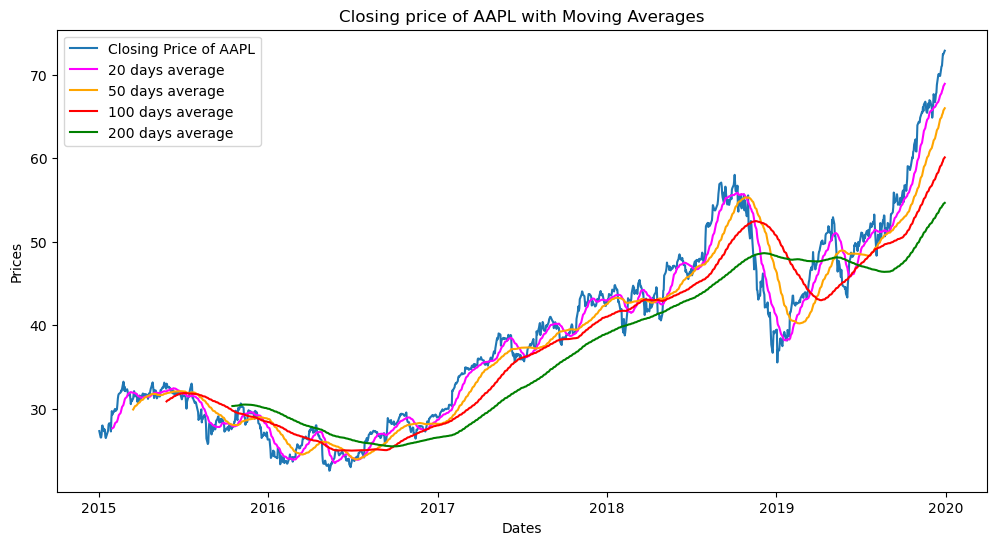

In [19]:
plt.figure(figsize = (12, 6))
plt.plot(data_aapl.Close, label = 'Closing Price of AAPL')
plt.plot(ma20, 'magenta', label = '20 days average')
plt.plot(ma50, 'orange', label = '50 days average')
plt.plot(ma100, 'r', label = '100 days average')
plt.plot(ma200, 'g', label = '200 days average')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of AAPL with Moving Averages')
plt.legend()

For 2019

In [20]:
data_aapl_2019 = pdr.get_data_yahoo(['AAPL'], start='2019-01-01', end='2019-12-31')
data_aapl_2019.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.943256,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.163822,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.622253,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.542965,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.220524,164101200


In [21]:
#2019
#Calculate moving average of first 50 days
ma20_2019 = data_aapl_2019.Close.rolling(20).mean()
#Calculate moving average of first 50 days
ma50_2019 = data_aapl_2019.Close.rolling(50).mean()
#Calculate moving average of first 100 days
ma100_2019 = data_aapl_2019.Close.rolling(100).mean()

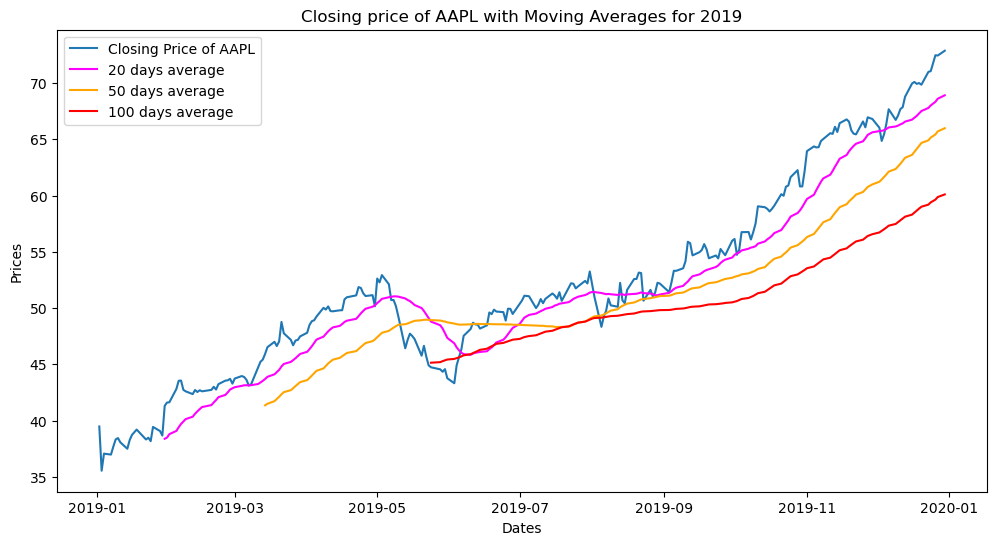

In [22]:
plt.figure(figsize = (12, 6))
plt.plot(data_aapl_2019.Close, label = 'Closing Price of AAPL')
plt.plot(ma20_2019, 'magenta', label = '20 days average')
plt.plot(ma50_2019, 'orange', label = '50 days average')
plt.plot(ma100_2019, 'r', label = '100 days average')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of AAPL with Moving Averages for 2019')
plt.legend()

### Cumulative Moving Average

In [23]:
cma_aapl = data_aapl.Close.expanding().mean()

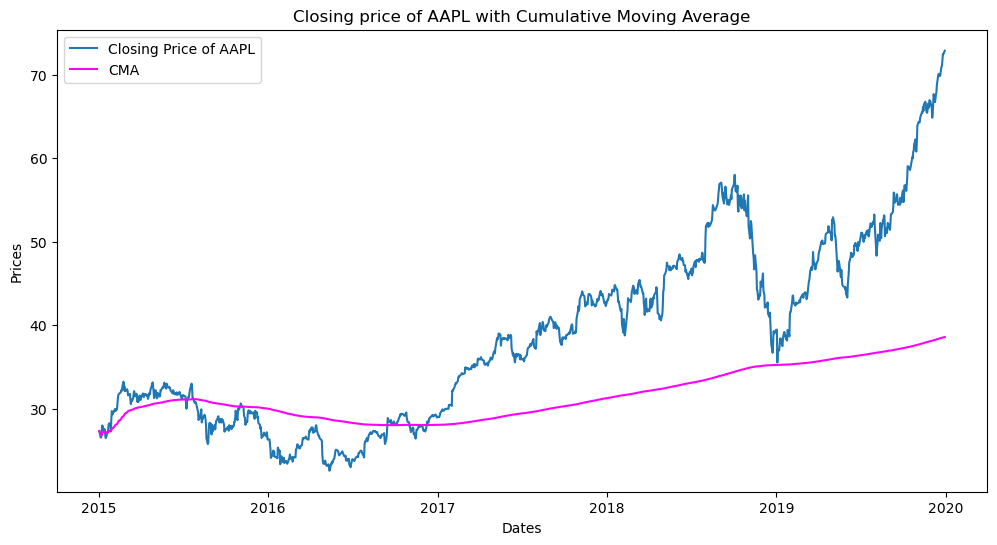

In [24]:
plt.figure(figsize = (12, 6))
plt.plot(data_aapl.Close, label = 'Closing Price of AAPL')
plt.plot(cma_aapl, 'magenta', label = 'CMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of AAPL with Cumulative Moving Average')
plt.legend()

In [25]:
#for 2019
cma_aapl_2019 = data_aapl_2019.Close.expanding().mean()

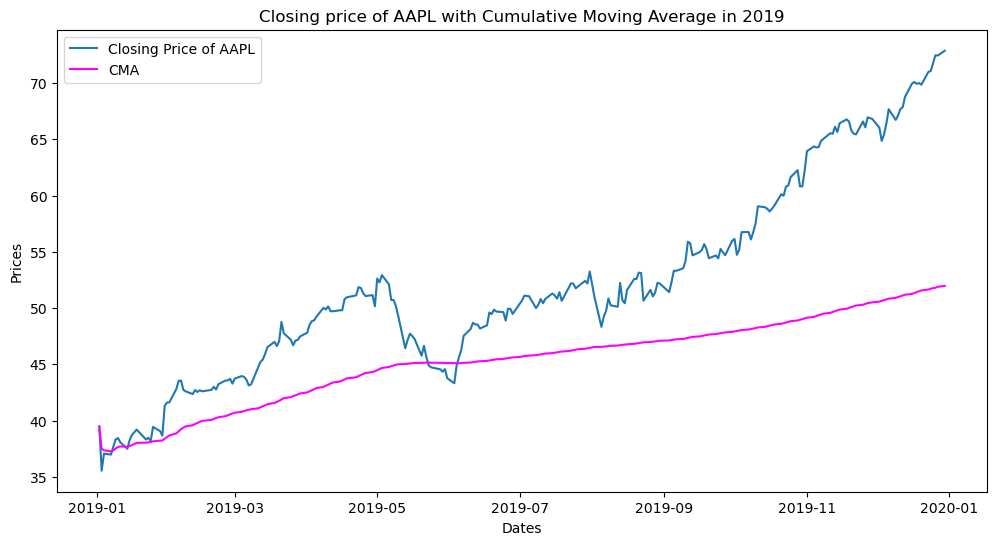

In [26]:
plt.figure(figsize = (12, 6))
plt.plot(data_aapl_2019.Close, label = 'Closing Price of AAPL')
plt.plot(cma_aapl_2019, 'magenta', label = 'CMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of AAPL with Cumulative Moving Average in 2019')
plt.legend()

### Exponential Weighted Moving Average (EWMA)

$ewma(t) = a * x(t) + (1-a) * ewma(t-1)$

where, $a \implies$ weight factor that gives higher priority to the price at time $t$ compared to the price at $t-1$ (This is done to prevent lags)

In [27]:
ewma_0 = data_aapl.Close.ewm(alpha = 0.1, adjust = False).mean()
ewma_1 = data_aapl.Close.ewm(alpha = 0.3, adjust = False).mean()

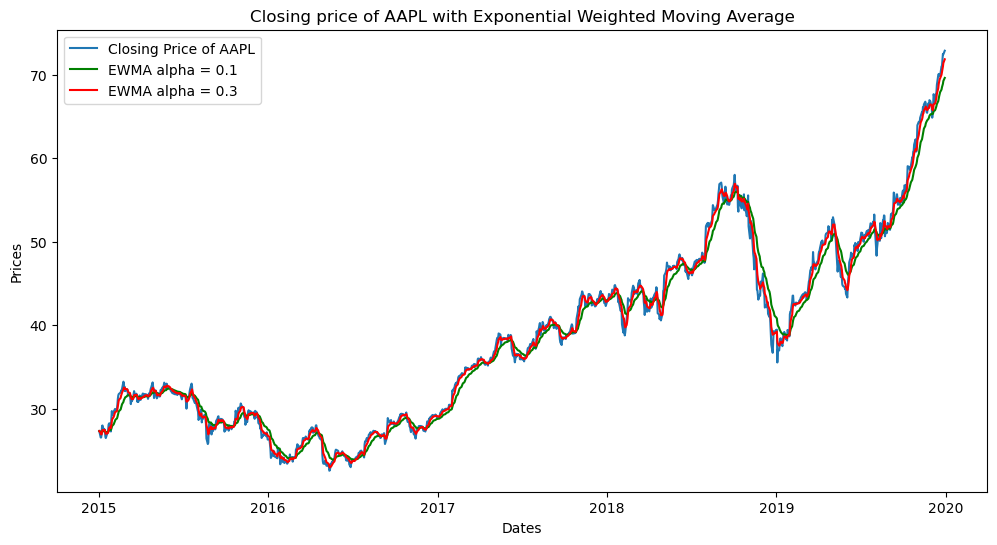

In [28]:
plt.figure(figsize = (12, 6))
plt.plot(data_aapl.Close, label = 'Closing Price of AAPL')
plt.plot(ewma_0, 'g', label = 'EWMA alpha = 0.1')
plt.plot(ewma_1, 'r', label = 'EWMA alpha = 0.3')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of AAPL with Exponential Weighted Moving Average')
plt.legend()

In [29]:
#for 2019
ewma_0_2019 = data_aapl_2019.Close.ewm(alpha = 0.1, adjust = False).mean()
ewma_1_2019 = data_aapl_2019.Close.ewm(alpha = 0.3, adjust = False).mean()

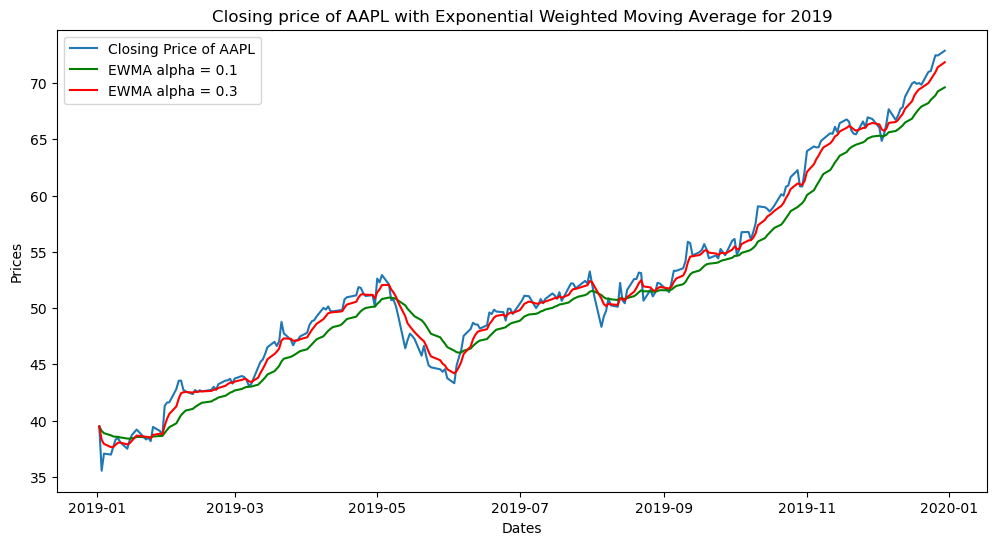

In [30]:
plt.figure(figsize = (12, 6))
plt.plot(data_aapl_2019.Close, label = 'Closing Price of AAPL')
plt.plot(ewma_0_2019, 'g', label = 'EWMA alpha = 0.1')
plt.plot(ewma_1_2019, 'r', label = 'EWMA alpha = 0.3')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of AAPL with Exponential Weighted Moving Average for 2019')
plt.legend()

### Check Trend and Seasonality

<Figure size 640x480 with 0 Axes>

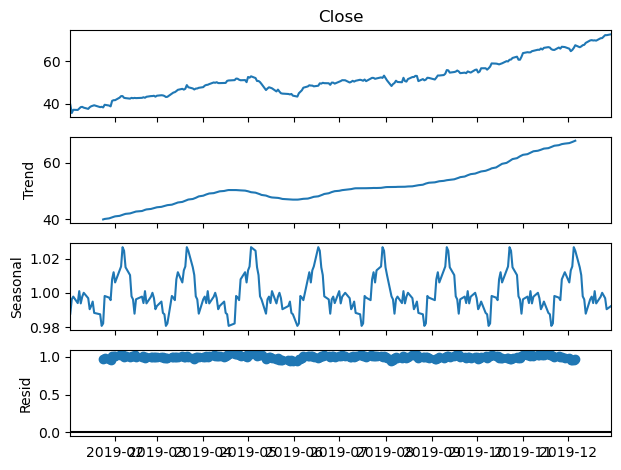

In [47]:
result = seasonal_decompose(data_aapl_2019.Close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  

### To check if the data is stationary or not (Dickey-Fuller Test)

One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a =1) 

Alternate Hypothesis: The series has no unit root. 

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

In [52]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print('Reject Null Hypothesis, The data is stationary')
    else:
        print('Fail to reject Null Hypothesis, The data is not stationary')

test_stationarity(data_aapl_2019.Close)

ADF Statistics: 0.5617593871760749
p-value: 0.9866341393786713
Fail to reject Null Hypothesis, The data is not stationary


Assuming a 95% confidence interval, the p-value is greater than 0.05. Hence we fail to reject the null hypothesis and say that the data is non-stationary. 

We need to convert the data into stationary form.

In [58]:
#Get first differencing
data_aapl_2019['First_differnce'] = data_aapl_2019.Close - data_aapl_2019.Close.shift(12)
data_aapl_2019.head()

,Open,High,Low,Close,Adj Close,Volume,First_differnce
Date,,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.943256,148158800,NaN
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.163822,365248800,NaN
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.622253,234428400,NaN
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.542965,219111200,NaN
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.220524,164101200,NaN


In [59]:
#Check Stationarity again
test_stationarity(data_aapl_2019['First_differnce'].dropna())

ADF Statistics: -3.0494443691805606
p-value: 0.030527872179804506
Reject Null Hypothesis, The data is stationary


Thus differencing once made the data stationary. 

The number of times we do differencing is a hyperparameter to the ARIMA model that we implement later on. 

Thus d = 1

### Auto-Corellation and Partial Auto-Corellation

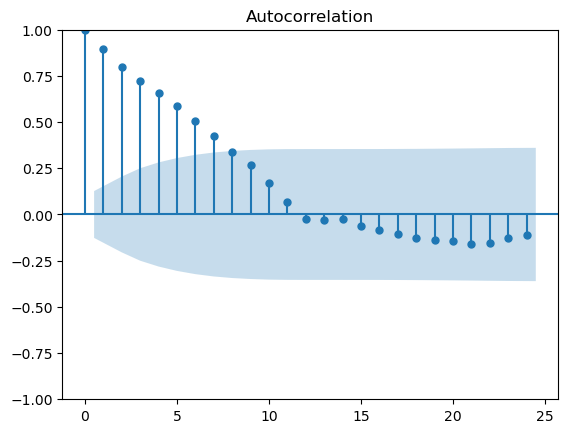

In [60]:
acf = plot_acf(data_aapl_2019['First_differnce'].dropna())

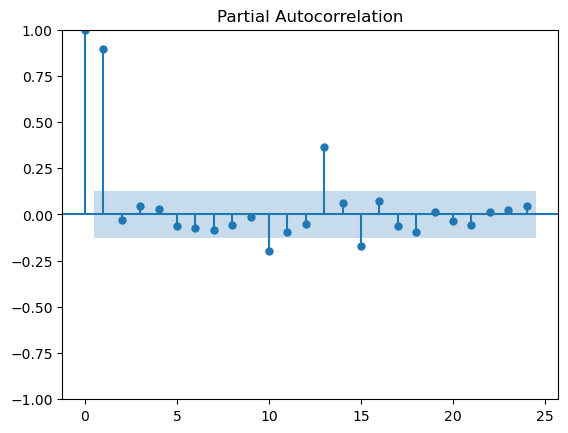

In [61]:
pacf = plot_pacf(data_aapl_2019['First_differnce'].dropna())

### Train-Test Split

In [62]:
train_data_end = dt.datetime(2019, 11, 30)
test_data_end = dt.datetime(2019, 12, 31)
train_data = data_aapl_2019[:train_data_end]
test_data = data_aapl_2019[train_data_end+dt.timedelta(days=1):test_data_end]

In [64]:
train_data.dropna().head()

,Open,High,Low,Close,Adj Close,Volume,First_differnce
Date,,,,,,,
2019-01-18,39.375000,39.470001,38.994999,39.205002,37.678959,135004000,-0.274998
2019-01-22,39.102501,39.182499,38.154999,38.325001,36.833218,121576000,2.777500
2019-01-23,38.537498,38.785000,37.924999,38.480000,36.982182,92522400,1.415001
2019-01-24,38.527500,38.619999,37.935001,38.174999,36.689056,101766000,1.192501
2019-01-25,38.869999,39.532501,38.580002,39.439999,37.904808,134142000,1.752499


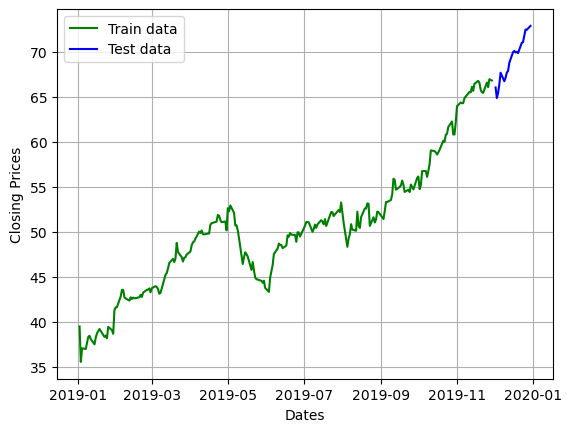

In [126]:
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.legend()

### Auto-Regressive Integrated Moving Average (ARIMA)

Parameters:

p: the number of lag observations in the model; also known as the lag order.

d: the number of times that the raw observations are differenced; also known as the degree of differencing.

q: the size of the moving average window; also known as the order of the moving average.


Lets automatically discover the optimal order (hyperparameters) for the model using auto_arima library

In [132]:
model_autoARIMA = auto_arima(train_data.Close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=558.609, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=559.321, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=559.018, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=561.532, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=560.009, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.175 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  231
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -277.305
Date:                Mon, 23 Oct 2023   AIC                            558.609
Time:                        17:07:28   BIC                            565.485
Sample:                             0   HQIC                           561.383
                                - 231                                         
Co

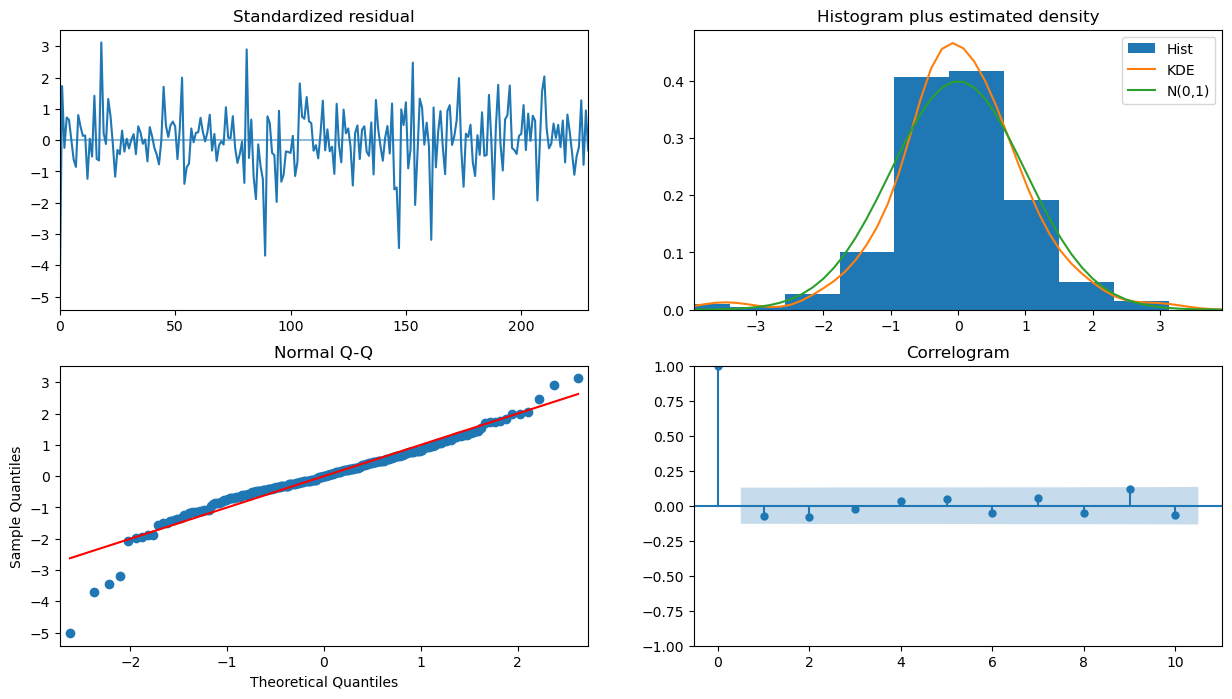

In [133]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [134]:
model_arima = ARIMA(train_data['Close'], order = (0, 1, 0))
model_fit = model_arima.fit()
model_fit.summary()


/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  231
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -279.766
Date:                Mon, 23 Oct 2023   AIC                            561.532
Time:                        17:10:01   BIC                            564.970
Sample:                             0   HQIC                           562.919
                                - 231                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6669      0.039     17.268      0.000       0.591       0.743
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):               154.33
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.72
Prob(H) (two-sided):                  0.57   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [135]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2019-12-02 00:00:00
2019-12-30 00:00:00


In [137]:
pred = model_fit.forecast(len(test_data.index), alpha=0.05)
pred = pd.DataFrame(pred)
pred.set_index(test_data.index, inplace=True)
pred

/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,predicted_mean
Date,
2019-12-02,66.8125
2019-12-03,66.8125
2019-12-04,66.8125
2019-12-05,66.8125
2019-12-06,66.8125
2019-12-09,66.8125
2019-12-10,66.8125
2019-12-11,66.8125
2019-12-12,66.8125


In [138]:
residuals = test_data['Close'] - pred['predicted_mean']
residuals

Date
2019-12-02   -0.772499
2019-12-03   -1.949997
2019-12-04   -1.377502
2019-12-05   -0.417503
2019-12-06    0.864998
2019-12-09   -0.082497
2019-12-10    0.307503
2019-12-11    0.879997
2019-12-12    1.052498
2019-12-13    1.974998
2019-12-16    3.152496
2019-12-17    3.290001
2019-12-18    3.122498
2019-12-19    3.192497
2019-12-20    3.047501
2019-12-23    4.187500
2019-12-24    4.254997
2019-12-26    5.665001
2019-12-27    5.637497
2019-12-30    6.067497
dtype: float64

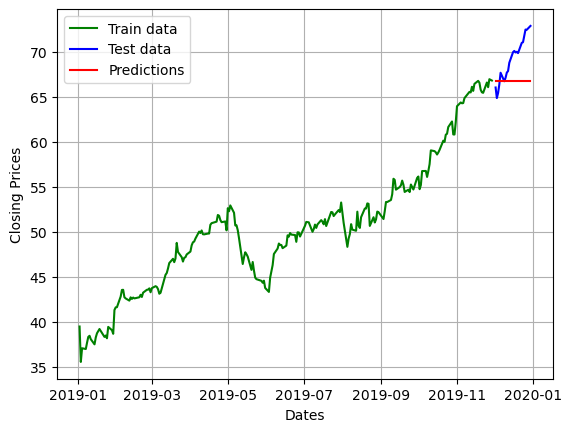

In [139]:
#Predicted Results
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.plot(pred['predicted_mean'], 'red', label = 'Predictions')
plt.legend()

Source:
- https://www.youtube.com/watch?v=s3CnE2tqQdo&t=365s
- https://www.youtube.com/watch?v=N9NqTp_D_bw